In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
from torchvision.io import read_image
# for reading and displaying images
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
import nibabel as nib
import glob
import random
import numpy as np
import os
from natsort import natsorted

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Previously written modules of aifnet

from aifnet_utils.preprocess import normalize_aif, normalize_single_volume, normalize_zero_one, normalize_volumes_in_sequence
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.deconv import save_nifti_from_array_and_referenceHeader
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
%matplotlib inline

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using {} device".format(device))

#Reading an example PCT volume
LOCATION = 'INSEL'

if LOCATION == 'HOME':
    ROOT_EXP = '/Users/admin/work/aifnet_replication-main'
    root_dir  = '/Users/admin/work/data/'


if LOCATION == 'LOCAL':
    ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/'
    root_dir  = '/Users/sebastianotalora/work/postdoc/data/ISLES/'

if LOCATION == 'INSEL':
    ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
    root_dir  = '/media/sebastian/data/ASAP/ISLES2018_Training'

if LOCATION == 'SERVER':
    ROOT_EXP = '/home/sotalora/aifnet_replication/'
    root_dir     = '/data/images/sotalora/ISLES18/'

aif_annotations_path = ROOT_EXP + 'radiologist_annotations.csv'


aif_annotations_path = ROOT_EXP + '/radiologist_annotations_cleaned.csv'#'radiologist_annotations.csv'#'annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43


Using cuda:0 device


In [4]:
class ISLESDataset(Dataset):
    def __init__(self, annotations_file, partition_file_path, 
                 minimum_number_volumes_ctp, img_dir, vascular_fn='AIF',
                 transform=None, target_transform=normalize_zero_one,
                 augment = True, delay_t=None):
        self.img_dir = img_dir
        self.transform = transform
        self.augment = augment
        self.delay_t = delay_t
        self.target_transform = target_transform
        self.minimum_number_volumes_ctp = minimum_number_volumes_ctp
        dataset_dir = os.path.join(img_dir, "TRAINING")
        dataset_dir_test = os.path.join(img_dir, "TESTING")
        self.filenames_4D = natsorted(glob.glob(dataset_dir + "/case_*/*4D*/*nii*") + glob.glob(dataset_dir_test + "/case_*/*4D*/*nii*"))
        self.cases_paths = {path.split('.')[-2]: path for path in self.filenames_4D}
        self.vascular_fn = vascular_fn
        partition_file = open(partition_file_path,'r')
        relevant_cases = []
        for line in partition_file:
            relevant_cases.append(line.split('.')[-2])
        partition_file.close()
        self.fold_img_paths = {key: self.cases_paths[key] for key in relevant_cases}
        self.fold_ids = [int(valid_indx) for valid_indx in list(self.fold_img_paths.keys())]
        self.all_labels = pd.read_csv(aif_annotations_path) 
        self.img_labels = self.all_labels[self.all_labels['imageID'].isin(self.fold_ids)]
        #print(self.fold_img_paths)
        
    def __len__(self):
        return len(self.fold_img_paths)

    def __getitem__(self, idx):
        img_id   = str(self.img_labels.iloc[idx]['imageID'])
        img_path = self.fold_img_paths[img_id]
        image    = read_volume_sequence(img_path,self.minimum_number_volumes_ctp)
        image    = normalize_volumes_in_sequence(image)#Normalizing the whole sequence
            
        AIF = image[self.img_labels.iloc[idx]['AIFx'],self.img_labels.iloc[idx]['AIFy'],self.img_labels.iloc[idx]['AIFz'],:]
        VOF = image[self.img_labels.iloc[idx]['VOFx'],self.img_labels.iloc[idx]['VOFy'],self.img_labels.iloc[idx]['VOFz'],:]
        label = AIF #By default return only the AIF
        
        if self.augment:
            augment_functions = [early_bolus,late_bolus]
            random_augmentation = random.choice(augment_functions)
            if self.delay_t == None:
                self.delay_t = np.random.randint(0,6)
                #print("Voy a aumentar con un delaz de " + str(self.delay_t))
            image, label = random_augmentation(image,label, self.delay_t)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.vascular_fn == 'VOF':
            label = VOF
        return torch.tensor(image.T), torch.tensor(label) #transpose since torch is happy when channels first
    

def read_volume_sequence(fname,minimum_number_volumes_ctp):
        cur_nib = nib.load(fname)
        ctp_vals = cur_nib.get_fdata()
        volume_sequence = ctp_vals[:,:,:,0:minimum_number_volumes_ctp]
        return volume_sequence

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [6]:
annotations_file = aif_annotations_path
current_fold = 1
minimum_number_volumes_ctp = 43
partition_file_training = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/train_v2.txt'
partition_file_valid = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/valid_v2.txt'
partition_file_test = ROOT_EXP + '/partitions_cleaned/fold_'+str(current_fold)+'/test_v2.txt'

training_data = ISLESDataset(
annotations_file, partition_file_training, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='VOF',
                 transform=None, target_transform=normalize_zero_one, augment=True
)
valid_data = ISLESDataset(
annotations_file, partition_file_valid, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='VOF',
                 transform=None, target_transform=normalize_zero_one, augment=False

)
test_data = ISLESDataset(
annotations_file, partition_file_test, 
                 minimum_number_volumes_ctp, root_dir, vascular_fn='VOF',
                 transform=None, target_transform=normalize_zero_one, augment=False

)


In [7]:
sample_idx = torch.randint(100, size=(1,)).item()
img, label = training_data[sample_idx]


In [8]:
img.dtype

torch.float64

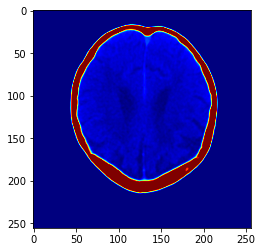

In [9]:
plt.imshow(img[0,1,:,:],cmap='jet')

In [10]:
print(np.array(label.cpu()).shape, img.shape)

(43,) torch.Size([43, 4, 256, 256])


Text(0, 0.5, 'Normalized Density (HU)')

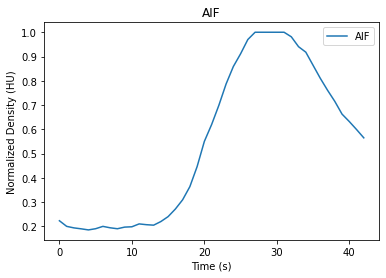

In [11]:
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)
plt.plot(label.cpu().numpy())
plt.legend([ 'AIF','VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [12]:
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=False)
test_dataloader  = DataLoader(test_data, batch_size=1, shuffle=False)


In [13]:
example_features, example_labels = next(iter(train_dataloader))
example_labels.shape

torch.Size([1, 43])

In [14]:
example_features.shape

torch.Size([1, 43, 8, 256, 256])

In [15]:
# Define model
class AIFNet(nn.Module):
    def __init__(self):
        super(AIFNet, self).__init__()
        
        self.firstConv3d  = self._conv3d_relu(in_c=43, out_c=16, k_size=(1,3,3),pad_size=(0,1,1))
        self.secondConv3d = self._conv3d_relu(in_c=16, out_c=32, k_size=(1,3,3),pad_size=(0,1,1))
        self.thirdConv3d  = self._conv3d_relu(in_c=32, out_c=64, k_size=(1,3,3),pad_size=(0,1,1))
        self.fourthConv3d = self._conv3d_relu(in_c=64, out_c=128, k_size=(1,3,3),pad_size=(0,1,1))
        self.Lout         = self._conv3d_relu(in_c=128, out_c=1, k_size=(1,3,3),pad_size=(0,1,1))
        self.softmax3d    = torch.nn.Softmax(dim=0)
        self.drop         = torch.nn.Dropout(p=0.3)
        
    def _conv3d_relu(self, in_c, out_c, k_size,pad_size=0):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=k_size,padding=pad_size,padding_mode='zeros'),
            nn.ReLU()
        )
        return conv_layer        
    def forward(self, input_x):
        x = torch.tensor(input_x)
        x = self.firstConv3d(input_x)
        x = self.drop(x)
        x = self.secondConv3d(x)
        x = self.drop(x)
        x = self.thirdConv3d(x)
        x = self.drop(x)
        x = self.fourthConv3d(x)
        x = self.Lout(x)
        pvol_shape = x.shape
        Pvol = self.softmax3d(x.flatten())
        Pvol = Pvol.reshape(pvol_shape)
        voxelwise_mult = torch.mul(Pvol,input_x)
        #print(voxelwise_mult.sum())
        aif_hat = voxelwise_mult.mean(dim=(-3,-2,-1)) #This should be [N,TimePoints]
        return aif_hat

model = AIFNet().to(device)
print(model)
if 'cuda' in device.type:
    model.double()

AIFNet(
  (firstConv3d): Sequential(
    (0): Conv3d(43, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (secondConv3d): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (thirdConv3d): Sequential(
    (0): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (fourthConv3d): Sequential(
    (0): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (Lout): Sequential(
    (0): Conv3d(128, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (softmax3d): Softmax(dim=0)
  (drop): Dropout(p=0.3, inplace=False)
)


In [16]:
def get_Pvol(input_sequence, model):
    return_layers = {'Lout': 'Lout'}
    mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)
    mid_outputs, model_output = mid_getter(input_sequence)
    Pvol = mid_outputs['Lout']
    pvol_shape = Pvol.shape
    Pvol = model.softmax3d(Pvol.flatten())
    Pvol = Pvol.reshape(pvol_shape)
    return Pvol

In [28]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_n):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        if X.shape[2] >5:
            continue
        #print(X.shape)
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))
        
        writer.add_scalar("Loss/train", loss, epoch_n)
        # Backpropagation    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(torch.tensor(X[np.newaxis,:,:,:,:]).to(device))
            test_loss += loss_fn(pred, torch.tensor(y)).item()
            correct += (pred.argmax(1) == torch.tensor(y)).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [19]:
def pearson_correl_loss(output, target,device='cuda'):
    target = target.to(device)
    output = output.to(device)
    #output = (output-output.min())/ (output.max()-output.min())
    #target = (target-target.min())/ (target.max()-target.min())
    y_true_mean = torch.mean(target)
    y_hat_mean = torch.mean(output)
    y_true_var = torch.var(target)
    y_hat_var = torch.var(output)
    y_true_std = torch.std(target)
    y_hat_std = torch.std(output)
    vx = target - torch.mean(target)
    vy = output - torch.mean(output)
    pcc = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2) + 0.000001) * torch.sqrt(torch.sum(vy ** 2) + 0.000001))
    ccc = (2 * pcc * y_true_std * y_hat_std)/(y_true_var + y_hat_var + (y_hat_mean - y_true_mean) ** 2)
    ccc = 1 - ccc
    loss = torch.mean((output - target)**2)
    return loss

In [26]:
train_initial = True
save_model = True
learning_rate = 1e-3
batch_size = 1
epochs = 4
# Initialize the loss function
loss_fn = pearson_correl_loss#nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#torch.optim.SGD(model.parameters(), lr=learning_rate)
path_initial_model = ROOT_EXP + '/models_pytorch/initial_model.pth'



writer = SummaryWriter(
    log_dir=ROOT_EXP + '/runs/',
    comment='',
    purge_step=None,
    max_queue=10,
    flush_secs=120,
    filename_suffix='VOF_lr_' + str(learning_rate)+'_opt_' + str(optimizer).split()[0],
)

In [36]:
if train_initial:
    model.train()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, t)
        #test_loop(test_dataloader, model, loss_fn)
    print("Done!")
    writer.flush()
    writer.close()
    #torch.save(model, path_initial_model)
else:
    # Model class must be defined somewhere
    model = torch.load(path_initial_model)


Epoch 1
-------------------------------


<ipython-input-15-d175cf82200a>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)


loss: 0.112674  [    0/  107]
loss: 0.550585  [   10/  107]
loss: 0.110577  [   20/  107]
loss: 0.106215  [   30/  107]
loss: 0.070730  [   40/  107]
loss: 0.135787  [   50/  107]
loss: 0.173372  [   60/  107]
loss: 0.177903  [   70/  107]
loss: 0.215276  [   80/  107]
loss: 0.212977  [   90/  107]
loss: 0.229543  [  100/  107]
Epoch 2
-------------------------------
loss: 0.135787  [    0/  107]
loss: 0.282899  [   20/  107]
loss: 0.206875  [   30/  107]
loss: 0.318704  [   40/  107]
loss: 0.149413  [   60/  107]
loss: 0.277813  [   70/  107]
loss: 0.250203  [   80/  107]
Epoch 3
-------------------------------
loss: 0.180583  [    0/  107]
loss: 0.432187  [   10/  107]
loss: 0.106215  [   20/  107]
loss: 0.568228  [   30/  107]
loss: 0.075977  [   40/  107]
loss: 0.070730  [   50/  107]
loss: 0.238742  [   60/  107]
loss: 0.275068  [   90/  107]
loss: 0.219922  [  100/  107]
Epoch 4
-------------------------------
loss: 0.399797  [    0/  107]
loss: 0.174725  [   20/  107]
loss: 0.43

In [33]:
path_initial_model

'/home/sebastian/experiments/aifnet_replication//models_pytorch/initial_model.pth'

In [31]:
if save_model:
    torch.save(model, path_initial_model)


In [34]:
def validation_loop(dataloader, model, loss_fn, return_preds=False):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds_gt = []
    count = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(torch.tensor(X).to(device))
            test_loss += loss_fn(torch.tensor(normalize_zero_one(pred.to('cpu').numpy())), torch.tensor(normalize_zero_one(torch.tensor(y).to('cpu').numpy()))).item()
            preds_gt.append([pred.to('cpu').numpy(), torch.tensor(y).to('cpu').numpy()])
            #if count == 9:
            #    break
            #count = count +1
        test_loss /= num_batches
        print(f" Avg loss: {test_loss:>8f} \n")
    if return_preds:
        preds_gt,test_loss
    return preds_gt,test_loss


In [35]:
preds_gt, val_loss = validation_loop(train_dataloader, model, loss_fn, return_preds=True)

<ipython-input-34-566797dea418>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(X).to(device))
<ipython-input-15-d175cf82200a>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)
/home/sebastian/experiments/aifnet_replication/aifnet_utils/preprocess.py:35: RuntimeWarning: invalid value encountered in true_divide
  normalized_zero_one = (x-np.min(x))/(np.max(x)-np.min(x))
<ipython-input-34-566797dea418>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss += loss_fn(torch.tensor(nor

 Avg loss:      nan 



In [53]:
preds_gt[7][0]

array([[7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06, 7.62939453e-06,
        7.62939453e-06, 7.62939453e-06, 7.62939453e-06]])

/home/sebastian/experiments/aifnet_replication/aifnet_utils/preprocess.py:35: RuntimeWarning: invalid value encountered in true_divide
  normalized_zero_one = (x-np.min(x))/(np.max(x)-np.min(x))


Text(0, 0.5, 'Normalized Density (HU)')

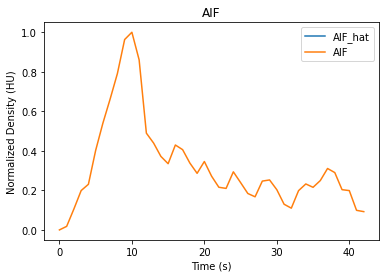

In [41]:
sample_idx = 4

plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)

plt.plot(normalize_zero_one(preds_gt[sample_idx][0][0]))
plt.plot(preds_gt[sample_idx][1][0])

plt.legend([ 'AIF_hat','AIF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


Text(0, 0.5, 'Normalized Density (HU)')

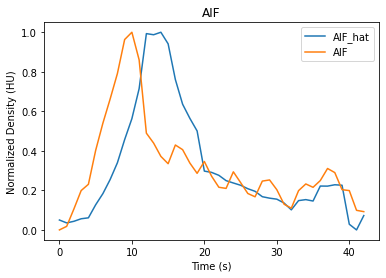

In [187]:
sample_idx = 4

plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)

plt.plot(normalize_zero_one(preds_gt[sample_idx][0][0]))
plt.plot(preds_gt[sample_idx][1][0])

plt.legend([ 'AIF_hat','AIF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [108]:
val_img_sample, val_label_sample = next(iter(valid_dataloader))


In [141]:
val_img_sample.dtype

torch.float32

In [130]:
sample_pvol.T[np.newaxis].shape

(1, 43, 16, 256, 256)

In [142]:
pp.dtype

torch.float64

In [209]:
model.double()

AIFNet(
  (firstConv3d): Sequential(
    (0): Conv3d(43, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (secondConv3d): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (thirdConv3d): Sequential(
    (0): Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (fourthConv3d): Sequential(
    (0): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (Lout): Sequential(
    (0): Conv3d(128, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): ReLU()
  )
  (softmax3d): Softmax(dim=0)
)

In [217]:
all_labels = pd.read_csv(aif_annotations_path) 
sample_pvol_path = '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_38/SMIR.Brain.XX.O.CT_4DPWI.345808/SMIR.Brain.XX.O.CT_4DPWI.345808.nii'
imgid = int(sample_pvol_path.split('.')[-2])
label_coords = all_labels[all_labels['imageID'] == imgid]

sample_pvol = read_volume_sequence(sample_pvol_path,43)
sample_pvol  = np.array(sample_pvol,dtype=np.double)#
sample_pvol = normalize_volumes_in_sequence(sample_pvol)#Normalizing the whole sequence



#img_path = self.fold_img_paths[img_id]
AIF = sample_pvol[label_coords['AIFx'],label_coords['AIFy'],label_coords['AIFz'],:]
VOF = sample_pvol[label_coords['VOFx'],label_coords['VOFy'],label_coords['VOFz'],:]


pp = torch.tensor(sample_pvol.T[np.newaxis],dtype=torch.double)
pvol = get_Pvol(pp.to(device), model)
pvol = pvol.to('cpu').detach().numpy()
pvol = pvol[0,0,:,:,:].T
print(pvol.shape)
save_nifti_from_array_and_referenceHeader(pvol,sample_pvol_path,sample_pvol_path.split('.')[-2]+'_pvol.nii')

(256, 256, 2)


<ipython-input-179-c1541db6cf8e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)


In [218]:
y_hat = model(pp)

<ipython-input-179-c1541db6cf8e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(input_x)


NotImplementedError: Could not run 'aten::slow_conv3d_forward' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::slow_conv3d_forward' is only available for these backends: [CPU, BackendSelect, Named, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, UNKNOWN_TENSOR_TYPE_ID, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:16286 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
ADInplaceOrView: fallthrough registered at /pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:60 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradMLC: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:9226 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_4.cpp:9909 [kernel]
Autocast: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:255 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/BatchingRegistrations.cpp:1019 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [ ]:

plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)

plt.plot(normalize_zero_one(preds_gt[sample_idx][0][0]))
plt.plot(preds_gt[sample_idx][1][0])

plt.legend([ 'AIF_hat','AIF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [212]:
pvol.shape

(256, 256, 2)

In [214]:
all_labels[all_labels['imageID'] == 346290]

,imageID,AIFx,AIFy,AIFz,VOFx,VOFy,VOFz
0,346290,82,141,0,138,58,1


In [215]:
sample_pvol_path.split('.')[-2]

'345808'

In [149]:
valid_data.fold_img_paths

{'346172': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_90/SMIR.Brain.XX.O.CT_4DPWI.346172/SMIR.Brain.XX.O.CT_4DPWI.346172.nii',
 '345808': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_38/SMIR.Brain.XX.O.CT_4DPWI.345808/SMIR.Brain.XX.O.CT_4DPWI.345808.nii',
 '346137': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_85/SMIR.Brain.XX.O.CT_4DPWI.346137/SMIR.Brain.XX.O.CT_4DPWI.346137.nii',
 '345561': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_1/SMIR.Brain.XX.O.CT_4DPWI.345561/SMIR.Brain.XX.O.CT_4DPWI.345561.nii',
 '345568': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_2/SMIR.Brain.XX.O.CT_4DPWI.345568/SMIR.Brain.XX.O.CT_4DPWI.345568.nii',
 '345990': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_64/SMIR.Brain.XX.O.CT_4DPWI.345990/SMIR.Brain.XX.O.CT_4DPWI.345990.nii',
 '345997': '/media/sebastian/data/ASAP/ISLES2018_Training/TRAINING/case_65/SMIR.Brain.XX.O.CT_4DPWI.345997/SMIR.Brain.XX.O.CT_4DPWI.